### CHE 620 HW13 - Problem 1: Blasius Equation, Boundary Value Problem

We are solving the Blasius BVP (Boundary layer flow past a semi-infinite flat plate)

$$
f''' + ff'' = 0
$$

subject to the boundary conditions $f(0) = f'(0) = 0,\, f'(\infty) = 1''.$
In this problem, $f = f(\eta),$ where $\eta$ is the similarity variable.
Numerical solutions of this problem truncate the similarity variable, usually between 8-12, since we cannot use $\infty$ numerically.

In [ ]:
using OrdinaryDiffEq
using BoundaryValueDiffEq

# u = [f, fp, fpp, a], where a is the unknown constant f''(0)
function blasius!(du, u, p, η)
    f, fp, fpp, a = u
    du[1] = fp
    du[2] = fpp
    du[3] = -f * fpp
    du[4] = 0.0
end

# Boundary conditions
function bc!(res, sol, p, mesh)
    uL = sol[1]          # at η = 0
    uR = sol[end]        # at η = ηmax

    res[1] = uL[1]            # f(0) = 0
    res[2] = uL[2]            # f'(0) = 0
    res[3] = uL[3] - uL[4]    # f''(0) - a = 0
    res[4] = uR[2] - 1.0      # f'(ηmax) = 1
end

ηmax = 10.0
tspan = (0.0, ηmax)

# Initial guess function
function guess(η)
    fp = 1 - exp(-η)
    f  = η + exp(-η) - 1
    fpp = exp(-η)
    a = 0.33
    return [f, fp, fpp, a]
end

prob = BVProblem(blasius!, bc!, guess, tspan)

sol = solve(prob, MIRK4(); dt=0.01, abstol=1e-10, reltol=1e-10)

a_est = sol(0.0)[4]
println("Estimated f''(0) = ", a_est)
println("Check f'(ηmax) = ", sol(ηmax)[2])

Estimated f''(0) = 0.4695999882843493
Check f'(ηmax) = 1.0


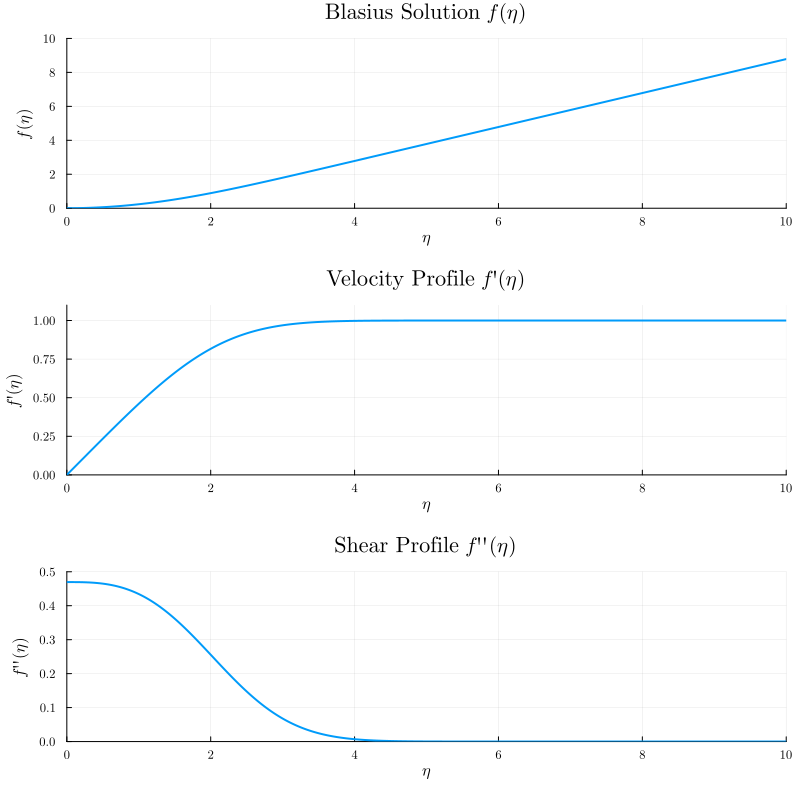

In [30]:
using Plots, LaTeXStrings
default(fontfamily="Computer Modern", lw=2)

η = range(0, ηmax, length=300)

f   = [sol(ηi)[1] for ηi in η]
fp  = [sol(ηi)[2] for ηi in η]
fpp = [sol(ηi)[3] for ηi in η]

p1 = plot(η, f,
    xlabel = L"\eta",
    ylabel = L"f(\eta)",
    title  = "Blasius Solution " * L"f(\eta)",
    legend = false,
    xlims  = (0, ηmax),
    ylims  = (0, 10))

p2 = plot(η, fp,
    xlabel = L"\eta",
    ylabel = L"f'(\eta)",
    title  = "Velocity Profile " * L"f'(\eta)",
    legend = false,
    xlims  = (0, ηmax),
    ylims  = (0, 1.1))

p3 = plot(η, fpp,
    xlabel = L"\eta",
    ylabel = L"f''(\eta)",
    title  = "Shear Profile " * L"f''(\eta)",
    legend = false,
    xlims  = (0, ηmax),
    ylims  = (0, 0.5))

plot(p1, p2, p3, layout=(3,1), size=(800,800))


### CHE 620 HW13 - Problem 2: Blasius Equation, Shooting Method

We now solve the Blasius BVP using the shooting method. Here, we treat $a:=f''(0)$ as a free parameter, integrate the IVP over $[\eta,\,\eta_{max}]$, we choose $a$ so that the BC $f'(\eta_{max})=1$ is satisfied.

In [ ]:
using OrdinaryDiffEq
using Roots

# Blasius in 1st-order form: f''' + f f'' = 0
# u = [f, fp, fpp]
function blasius_ivp!(du, u, p, η)
    f, fp, fpp = u
    du[1] = fp
    du[2] = fpp
    du[3] = -f * fpp
end

ηmax = 10.0
tspan = (0.0, ηmax)

# For a given a = f''(0), integrate and return mismatch fp(ηmax)-1
function mismatch(a; reltol=1e-10, abstol=1e-10)
    u0 = [0.0, 0.0, a]  # f(0)=0, f'(0)=0, f''(0)=a
    prob = ODEProblem(blasius_ivp!, u0, tspan)
    sol = solve(prob, Vern9(); reltol=reltol, abstol=abstol)
    return sol(ηmax)[2] - 1.0
end

# Bracket the root
a_lo, a_hi = 0.2, 0.8
println("mismatch(a_lo) = ", mismatch(a_lo))
println("mismatch(a_hi) = ", mismatch(a_hi))

# Solve mismatch(a)=0 using a robust bracketed method
a_star = find_zero(a -> mismatch(a), (a_lo, a_hi), Roots.Bisection())
println("Estimated f''(0) = ", a_star)

# Get the full solution with the found a_star
u0 = [0.0, 0.0, a_star]
prob = ODEProblem(blasius_ivp!, u0, tspan)
sol = solve(prob, Vern9(); reltol=1e-10, abstol=1e-10)

println("Check f'(ηmax) = ", sol(ηmax)[2])


mismatch(a_lo) = -0.4339328594334124
mismatch(a_hi) = 0.42639981227461576
Estimated f''(0) = 0.4695999883609133
Check f'(ηmax) = 0.9999999999999928


### CHE 620 HW13 - Problem 3: Blasius Equation, Initial Value Problem

We want to show that, if $F(\eta)$ is a solution, then so is $g(\eta) := aF(a\eta)$, where $a$ is a constant.

$$
F''' + FF'' = 0
$$

subject to the initial conditions $F(0) = F'(0) = 0,\, F'(0) = 1''.$ If $a$ is chosen to satisfy

$$
a^{-2} = \lim_{\eta \rightarrow \infty} F'(\eta),
$$

then $g(\eta) := aF(a\eta)$ is the desired solution.

We can obtain the derivatives:

$$
g'(\eta)=a^2f'(a\eta),\,g''(\eta)=a^3f''(a\eta),\,g'''(\eta)=a^4f'''(a\eta).
$$

The problem now reads:

$$
g''' + gg'' = a^4 (f'''+ff'')\vert_{a\eta} = 0,
$$

subject to the boundary conditions $g(0) = g'(0) = 0$ and the far field condition

$$
g'(\infty) = \lim_{\eta\rightarrow\infty}a^2f'(a\eta) = a^2f'(\infty).
$$

Now we let $F(\eta)$ solve the IVP, then we obtain from the far field condition:

$$
f'(\infty) = \lim_{\eta\rightarrow\infty} a^2F'(a\eta) = a^2 \lim_{s\rightarrow\infty} F'(s)
$$

To enforce the far field BC $f'(\infty) = 1$, we obtain $a^{-2} = \lim_{\eta\rightarrow\infty} F'(\eta)$.

From the derivatives, we also have $f''(0) = a^3 F''(0) = a^3$

In [ ]:
using OrdinaryDiffEq

# F''' + F F'' = 0
# u = [F, Fp, Fpp]
function blasius_F!(du, u, p, η)
    F, Fp, Fpp = u
    du[1] = Fp
    du[2] = Fpp
    du[3] = -F * Fpp
end

# Take large enough so F' is near its asymptote
ηmax = 20.0                      
prob = ODEProblem(blasius_F!, [0.0, 0.0, 1.0], (0.0, ηmax))

sol = solve(prob, Vern9(); reltol=1e-12, abstol=1e-12)

L = sol(ηmax)[2] # ≈ lim_{η→∞} F'(η)
a = 1 / sqrt(L)

println("Approx L = lim F'(η) ≈ ", L)
println("a = 1/sqrt(L) ≈ ", a)
println("Recovered f''(0) = a^3 ≈ ", a^3)

# Define the scaled Blasius solution f(η) = a F(aη)
f_sc(η)  = a * sol(a*η)[1]
fp_sc(η) = a^2 * sol(a*η)[2]
fpp_sc(η)= a^3 * sol(a*η)[3]

println("Check fp(∞) ≈ fp(ηmax/a) ≈ ", fp_sc(ηmax/a))

Approx L = lim F'(η) ≈ 1.655190360230833
a = 1/sqrt(L) ≈ 0.7772773738996601
Recovered f''(0) = a^3 ≈ 0.46959998836101297
Check fp(∞) ≈ fp(ηmax/a) ≈ 1.0


#### Comparing the approaches used to solve the Blasius equation.

* Problem 1, BVP solution: directly solving for the unknown $f''(0)$ to satisfy $f'(\infty)=1$
* Problem 2, shooting: finding $f''(0)$ via IVP and root finding
* Problem 3, IVP solution: solves the IVP $F''(0)=1$, asymptotic analysis of $\lim F'$, rescaling via $a=1/\sqrt{L}$